# 모델 병합

## 필요 라이브러리

In [1]:
import copy
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)    
matplotlib.rcParams['axes.unicode_minus'] = False      
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 150)

from xgboost import XGBRegressor

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device

random_seed = 616

## 데이터 불러오기

In [2]:
data = pd.read_excel('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data.columns.values]
max_seq = data['홍수사상번호'].value_counts().max() # RNN 모델을 위한 max_seq 저장

In [3]:
data.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1_유역평균강수,데이터집단 1_강우(A지역),데이터집단 1_강우(B지역),데이터집단 1_강우(C지역),데이터집단 1_강우(D지역),데이터집단 1_수위(E지역),데이터집단 1_수위(D지역),데이터집단 2_유역평균강수,데이터집단 2_강우(A지역),데이터집단 2_강우(B지역),데이터집단 2_강우(C지역),데이터집단 2_강우(D지역),데이터집단 2_수위(E지역),데이터집단 2_수위(D지역),데이터집단 3_유역평균강수,데이터집단 3_강우(A지역),데이터집단 3_강우(B지역),데이터집단 3_강우(C지역),데이터집단 3_강우(D지역),데이터집단 3_수위(E지역),데이터집단 3_수위(D지역),데이터 집단 4_유역평균강수,데이터 집단 4_강우(A지역),데이터 집단 4_강우(B지역),데이터 집단 4_강우(C지역),데이터 집단 4_강우(D지역),데이터 집단 4_수위(E지역),데이터 집단 4_수위(D지역),데이터 집단 5_유역평균강수,데이터 집단 5_강우(A지역),데이터 집단 5_강우(B지역),데이터 집단 5_강우(C지역),데이터 집단 5_강우(D지역),데이터 집단 5_수위(E지역),데이터 집단 5_수위(D지역),데이터 집단 6_유역평균강수,데이터 집단 6_강우(A지역),데이터 집단 6_강우(B지역),데이터 집단 6_강우(C지역),데이터 집단 6_강우(D지역),데이터 집단 6_수위(E지역),데이터 집단 6_수위(D지역)
0,1,2006,7,10,8,189.10,6.40,7,7,7,8,2.54,122.57,6.30,7,7,7,8,2.54,122.54,6.30,7,7,7,8,2.54,122.55,6.40,7,7,8,8,2.54,122.67,6.40,7,7,8,8,2.54,122.66,6.40,7,7,8,8,2.54,122.61
1,1,2006,7,10,9,216.95,6.30,7,8,7,8,2.53,122.56,6.40,7,8,7,8,2.53,122.55,6.40,7,8,7,8,2.53,122.56,7.30,7,8,10,10,2.53,122.67,7.30,7,8,10,10,2.53,122.65,7.30,7,8,10,10,2.53,122.60
2,1,2006,7,10,10,251.42,6.40,7,9,7,8,2.53,122.56,7.30,7,9,7,8,2.53,122.56,7.30,7,9,8,8,2.53,122.57,8.20,7,9,10,11,2.53,122.66,8.20,7,9,10,11,2.53,122.64,8.20,7,9,10,11,2.53,122.59
3,1,2006,7,10,11,302.81,7.30,7,10,7,8,2.53,122.56,8.20,7,10,8,8,2.53,122.57,8.20,7,10,10,10,2.53,122.58,11.30,9,10,15,14,2.53,122.65,11.30,9,10,15,14,2.53,122.62,11.30,9,10,15,14,2.53,122.58
4,1,2006,7,10,12,384.78,8.20,7,12,8,10,2.53,122.56,11.30,9,12,10,10,2.53,122.58,11.30,9,12,10,11,2.53,122.58,14.40,12,12,18,16,2.53,122.64,14.40,12,12,18,16,2.53,122.60,14.40,12,12,18,16,2.53,122.58


In [4]:
test_data = data[data.isnull().any(axis=1)] # 유입량이 null값이 데이터는 test용 데이터
data = data[data.notnull().all(axis=1)]

In [5]:
y_col = '유입량'
PK_col = ['홍수사상번호','연','월','일','시간']

In [6]:
# 홍수사상번호 기준으로 split
# randomseed를 사용하여 고정

hongsu_idx = list(data['홍수사상번호'].unique())
random.seed(random_seed)
valid_hongsu_idx = random.sample(hongsu_idx, k= int(len(hongsu_idx)*0.3))

print(f"valid 홍수사상번호 : {sorted(valid_hongsu_idx)}")

valid 홍수사상번호 : [1, 6, 11, 15, 17, 18, 23]


In [7]:
train = data[~data['홍수사상번호'].isin(valid_hongsu_idx)]
valid = data[data['홍수사상번호'].isin(valid_hongsu_idx)]

X_train = train.drop(columns=[y_col]+PK_col)
y_train = train[y_col]

X_valid = valid.drop(columns=[y_col]+PK_col)
y_valid = valid[y_col]

print(f"train shape : {X_train.shape} valid shape : {X_valid.shape}")

train shape : (1929, 42) valid shape : (962, 42)


### t-1시점의 유입량 만들기

In [8]:
data_before = data.copy()
data_before['유입량_shift'] = data_before['유입량'].shift()
data_before['홍수사상번호_shift'] = data_before['홍수사상번호'].shift()
data_before.loc[(data['홍수사상번호'] != data_before['홍수사상번호_shift']), '유입량_shift'] = -999
data_before = data_before.drop(columns=['홍수사상번호_shift'])

In [9]:
data_before[['유입량', '유입량_shift']].head()

,유입량,유입량_shift
0,189.10,-999.00
1,216.95,189.10
2,251.42,216.95
3,302.81,251.42
4,384.78,302.81


In [10]:
train_before = data_before[~data_before['홍수사상번호'].isin(valid_hongsu_idx)]
valid_before = data_before[data_before['홍수사상번호'].isin(valid_hongsu_idx)]

X_train_before = train_before.drop(columns=[y_col]+PK_col)
y_train_before = train_before[y_col]

X_valid_before = valid_before.drop(columns=[y_col]+PK_col)
y_valid_before = valid_before[y_col]

print(f"train shape : {X_train_before.shape} valid shape : {X_valid_before.shape}")

train shape : (1929, 43) valid shape : (962, 43)


In [11]:
# 결과 값 저장할 dataframe 생성

valid_predict = pd.DataFrame()
valid_predict[PK_col] = valid[PK_col]
valid_predict['true'] = y_valid.values

mse_df = pd.DataFrame(columns=['MSE'])

## 1. Basic Model
 - xgboost 모델 사용

In [12]:
model_name = "Basic Model"

### 예측

In [13]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

pred_valid = xgb.predict(X_valid)

valid_predict[f'pred_{model_name}'] = pred_valid
valid_predict[f'error_{model_name}'] = abs(valid_predict['true'] - valid_predict[f'pred_{model_name}'])
valid_predict[f'error_percent_{model_name}'] = valid_predict[f'error_{model_name}'] / valid_predict['true'] * 100

In [14]:
valid_predict

,홍수사상번호,연,월,일,시간,true,pred_Basic Model,error_Basic Model,error_percent_Basic Model
0,1,2006,7,10,8,189.10,116.68,72.42,38.30
1,1,2006,7,10,9,216.95,119.43,97.52,44.95
2,1,2006,7,10,10,251.42,119.43,131.99,52.50
3,1,2006,7,10,11,302.81,205.85,96.97,32.02
4,1,2006,7,10,12,384.78,218.41,166.37,43.24
...,...,...,...,...,...,...,...,...,...
2689,23,2013,7,24,22,1441.65,1274.75,166.90,11.58
2690,23,2013,7,24,23,1425.44,1345.57,79.87,5.60
2691,23,2013,7,24,24,1403.87,1294.46,109.41,7.79
2692,23,2013,7,25,1,1379.03,1250.61,128.43,9.31


In [15]:
mse = mean_squared_error(y_valid, pred_valid)

print(f"Mean Squared Error : {mse:.2f}")

mse_df.loc[model_name, 'MSE'] = mse
mse_df

Mean Squared Error : 2167162.55


,MSE
Basic Model,2167162.55


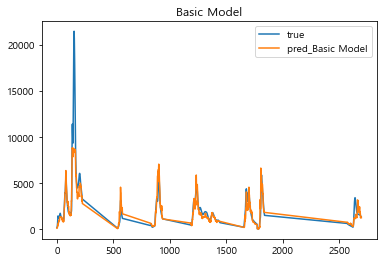

In [16]:
valid_predict[['true', f'pred_{model_name}']].plot()
plt.title(f"{model_name}")
plt.show()

## 2. xgboost_t-1 추가
 - xgboost 모델 사용  
 - t-1 데이터 추가

In [17]:
model_name = "XGB before"

### 예측

In [18]:
xgb = XGBRegressor()
xgb.fit(X_train_before, y_train_before)

pred_valid = xgb.predict(X_valid_before)

valid_predict[f'pred_{model_name}'] = pred_valid
valid_predict[f'error_{model_name}'] = abs(valid_predict['true'] - valid_predict[f'pred_{model_name}'])
valid_predict[f'error_percent_{model_name}'] = valid_predict[f'error_{model_name}'] / valid_predict['true'] * 100

In [19]:
valid_predict

,홍수사상번호,연,월,일,시간,true,pred_Basic Model,error_Basic Model,error_percent_Basic Model,pred_XGB before,error_XGB before,error_percent_XGB before
0,1,2006,7,10,8,189.10,116.68,72.42,38.30,206.82,17.72,9.37
1,1,2006,7,10,9,216.95,119.43,97.52,44.95,193.74,23.21,10.70
2,1,2006,7,10,10,251.42,119.43,131.99,52.50,217.65,33.77,13.43
3,1,2006,7,10,11,302.81,205.85,96.97,32.02,254.31,48.50,16.02
4,1,2006,7,10,12,384.78,218.41,166.37,43.24,313.18,71.61,18.61
...,...,...,...,...,...,...,...,...,...,...,...,...
2689,23,2013,7,24,22,1441.65,1274.75,166.90,11.58,1490.74,49.09,3.41
2690,23,2013,7,24,23,1425.44,1345.57,79.87,5.60,1481.00,55.55,3.90
2691,23,2013,7,24,24,1403.87,1294.46,109.41,7.79,1469.35,65.48,4.66
2692,23,2013,7,25,1,1379.03,1250.61,128.43,9.31,1378.87,0.16,0.01


In [20]:
mse = mean_squared_error(y_valid_before, pred_valid)

print(f"Mean Squared Error : {mse:.2f}")

mse_df.loc[model_name, 'MSE'] = mse
mse_df

Mean Squared Error : 1929805.61


,MSE
Basic Model,2167162.55
XGB before,1929805.61


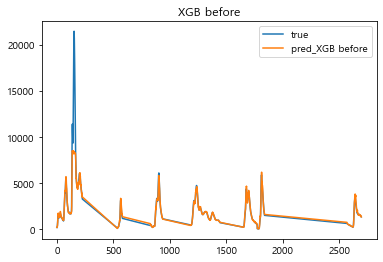

In [21]:
valid_predict[['true', f'pred_{model_name}']].plot()
plt.title(f"{model_name}")
plt.show()

## 3. LSTM
 - LSTM 모델 사용

In [22]:
model_name = "LSTM"

In [23]:
# LSTM에 넣기 위해 sequence 데이터로 바꿔주는 함수

def to_sequence(data, max_seq, scaler=None):
    X = []
    y = []
    seq_len = []
    end_pad = pd.DataFrame(columns=data.columns, data=[[0]*len(data.columns)])
    for hongsu_num in data['홍수사상번호'].unique():
        temp_df = data[data['홍수사상번호'] == hongsu_num]
        seq_len.append(len(temp_df))
        temp_df = pd.concat([temp_df, end_pad.loc[end_pad.index.repeat(max_seq - len(temp_df))]])
        
        X_temp = temp_df.drop(columns=[y_col]+PK_col)
        y_temp = temp_df[y_col]
        
        X_temp = X_temp.values
        y_temp = y_temp.values
        
        if scaler != None:
            scaler.fit(X_temp)
            X_temp = scaler.transform(X_temp)

        X.append(X_temp)
        y.append(y_temp)

    X = np.array(X)
    y = np.array(y)
    
    return X, y, seq_len

In [24]:
scaler = MinMaxScaler()

X_train_seq, y_train_seq, train_seq_len = to_sequence(train, max_seq, scaler)
X_valid_seq, y_valid_seq, valid_seq_len = to_sequence(valid, max_seq, scaler)

print(f"train data shape : {X_train_seq.shape} valid data shape : {X_valid_seq.shape}")
print(f"train label shape : {y_train_seq.shape} valid label shape : {y_valid_seq.shape}")

train data shape : (18, 285, 42) valid data shape : (7, 285, 42)
train label shape : (18, 285) valid label shape : (7, 285)


In [25]:
X_train_tensors = torch.Tensor(X_train_seq).to(device)
X_valid_tensors = torch.Tensor(X_valid_seq).to(device)

y_train_tensors = torch.Tensor(y_train_seq).to(device)
y_valid_tensors = torch.Tensor(y_valid_seq).to(device)

In [26]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU() 

    def forward(self,x):
        x, _status = self.lstm(x) #lstm with input, hidden, and internal state
        x = self.relu(x)
        x = self.fc1(x) #Final Output
        x = self.relu(x)
        x = self.fc2(x) #Final Output
        return x

In [27]:
num_epochs = 1000
learning_rate = 0.01

input_size = X_train_tensors.shape[2] #number of features
hidden_size = input_size #number of features in hidden state
num_layers = 2 #number of stacked lstm layers
seq_length = X_train_tensors.shape[1] #number of seq_length

num_classes = 1 #number of output classes 
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
# weight 초기화
for name, param in lstm.named_parameters():
    if 'weight_' in name:
        torch.nn.init.xavier_uniform_(param)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)  # adam optimizer

In [28]:
best_loss = 1E+10
best_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = lstm(X_train_tensors)
    loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        lstm.eval()
        outputs_valid = lstm(X_valid_tensors)
        loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
        lstm.train()
        
    if loss_valid < best_loss:
        best_loss = loss_valid
        best_epoch = epoch
        best_model = copy.deepcopy(lstm)
    
    if (epoch+1) % (num_epochs//10) == 0:
        print("Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))

Epoch: 100, Train Loss: 1589915.00 Best Epoch: 100 Best Valid Loss: 5797969.50
Epoch: 200, Train Loss: 1164484.38 Best Epoch: 200 Best Valid Loss: 4962028.50
Epoch: 300, Train Loss: 445383.03 Best Epoch: 290 Best Valid Loss: 3432032.75
Epoch: 400, Train Loss: 171938.95 Best Epoch: 371 Best Valid Loss: 3013966.50
Epoch: 500, Train Loss: 71704.84 Best Epoch: 371 Best Valid Loss: 3013966.50
Epoch: 600, Train Loss: 48122.64 Best Epoch: 371 Best Valid Loss: 3013966.50
Epoch: 700, Train Loss: 25463.27 Best Epoch: 371 Best Valid Loss: 3013966.50
Epoch: 800, Train Loss: 18927.00 Best Epoch: 371 Best Valid Loss: 3013966.50
Epoch: 900, Train Loss: 20230.86 Best Epoch: 371 Best Valid Loss: 3013966.50
Epoch: 1000, Train Loss: 10795.34 Best Epoch: 371 Best Valid Loss: 3013966.50


In [29]:
with torch.no_grad():
    best_model.eval()
    pred_valid_seq = best_model(X_valid_tensors).view(-1).detach().cpu().numpy()

pred_valid = []
count = 0
for seq_len in valid_seq_len:
    pred_valid += list(pred_valid_seq[count*max_seq:count*max_seq + seq_len])

valid_predict[f'pred_{model_name}'] = pred_valid
valid_predict[f'error_{model_name}'] = abs(valid_predict['true'] - valid_predict[f'pred_{model_name}'])
valid_predict[f'error_percent_{model_name}'] = valid_predict[f'error_{model_name}'] / valid_predict['true'] * 100

C:\Users\felab\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:576: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:1264.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [30]:
mse = mean_squared_error(y_valid, pred_valid)

print(f"Mean Squared Error : {mse:.2f}")

mse_df.loc[model_name, 'MSE'] = mse
mse_df

Mean Squared Error : 8000352.21


,MSE
Basic Model,2167162.55
XGB before,1929805.61
LSTM,8000352.21


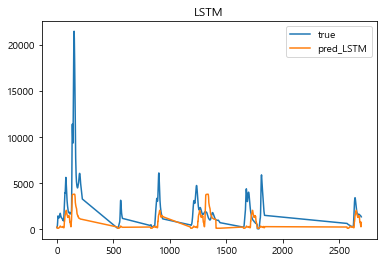

In [31]:
valid_predict[['true', f'pred_{model_name}']].plot()
plt.title(f"{model_name}")
plt.show()

## 4. LSTM + t-1 데이터
 - LSTM 모델 사용
 - t-1 데이터 추가

In [32]:
model_name = "LSTM before"

In [33]:
# LSTM에 넣기 위해 sequence 데이터로 바꿔주는 함수

def to_sequence(data, max_seq, scaler=None):
    X = []
    y = []
    seq_len = []
    end_pad = pd.DataFrame(columns=data.columns, data=[[0]*len(data.columns)])
    for hongsu_num in data['홍수사상번호'].unique():
        temp_df = data[data['홍수사상번호'] == hongsu_num]
        seq_len.append(len(temp_df))
        temp_df = pd.concat([temp_df, end_pad.loc[end_pad.index.repeat(max_seq - len(temp_df))]])
        
        X_temp = temp_df.drop(columns=[y_col]+PK_col)
        y_temp = temp_df[y_col]
        
        X_temp = X_temp.values
        y_temp = y_temp.values
        
        if scaler != None:
            scaler.fit(X_temp)
            X_temp = scaler.transform(X_temp)

        X.append(X_temp)
        y.append(y_temp)

    X = np.array(X)
    y = np.array(y)
    
    return X, y, seq_len

In [34]:
scaler = MinMaxScaler()

X_train_seq, y_train_seq, train_seq_len = to_sequence(train_before, max_seq, scaler)
X_valid_seq, y_valid_seq, valid_seq_len = to_sequence(valid_before, max_seq, scaler)

print(f"train data shape : {X_train_seq.shape} valid data shape : {X_valid_seq.shape}")
print(f"train label shape : {y_train_seq.shape} valid label shape : {y_valid_seq.shape}")

train data shape : (18, 285, 43) valid data shape : (7, 285, 43)
train label shape : (18, 285) valid label shape : (7, 285)


In [35]:
X_train_tensors = torch.Tensor(X_train_seq).to(device)
X_valid_tensors = torch.Tensor(X_valid_seq).to(device)

y_train_tensors = torch.Tensor(y_train_seq).to(device)
y_valid_tensors = torch.Tensor(y_valid_seq).to(device)

In [36]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU() 

    def forward(self,x):
        x, _status = self.lstm(x) #lstm with input, hidden, and internal state
        x = self.relu(x)
        x = self.fc1(x) #Final Output
        x = self.relu(x)
        x = self.fc2(x) #Final Output
        return x

In [37]:
num_epochs = 5000
learning_rate = 0.01

input_size = X_train_tensors.shape[2] #number of features
hidden_size = input_size #number of features in hidden state
num_layers = 2 #number of stacked lstm layers
seq_length = X_train_tensors.shape[1] #number of seq_length

num_classes = 1 #number of output classes 
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
# weight 초기화
for name, param in lstm.named_parameters():
    if 'weight_' in name:
        torch.nn.init.xavier_uniform_(param)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)  # adam optimizer

In [38]:
best_loss = 1E+10
best_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = lstm(X_train_tensors)
    loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        lstm.eval()
        outputs_valid = lstm(X_valid_tensors)
        loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
        lstm.train()
        
    if loss_valid < best_loss:
        best_loss = loss_valid
        best_epoch = epoch
        best_model = copy.deepcopy(lstm)
    
    if (epoch+1) % (num_epochs//10) == 0:
        print("Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))

Epoch: 500, Train Loss: 52310.43 Best Epoch: 467 Best Valid Loss: 2346162.25
Epoch: 1000, Train Loss: 5724.05 Best Epoch: 955 Best Valid Loss: 2033589.00
Epoch: 1500, Train Loss: 4727.38 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 2000, Train Loss: 2484.77 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 2500, Train Loss: 1853.13 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 3000, Train Loss: 1635.62 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 3500, Train Loss: 5736.97 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 4000, Train Loss: 2528.02 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 4500, Train Loss: 1530.08 Best Epoch: 1330 Best Valid Loss: 1997295.75
Epoch: 5000, Train Loss: 1621.50 Best Epoch: 1330 Best Valid Loss: 1997295.75


In [39]:
with torch.no_grad():
    best_model.eval()
    pred_valid_seq = best_model(X_valid_tensors).view(-1).detach().cpu().numpy()

pred_valid = []
count = 0
for seq_len in valid_seq_len:
    pred_valid += list(pred_valid_seq[count*max_seq:count*max_seq + seq_len])

valid_predict[f'pred_{model_name}'] = pred_valid
valid_predict[f'error_{model_name}'] = abs(valid_predict['true'] - valid_predict[f'pred_{model_name}'])
valid_predict[f'error_percent_{model_name}'] = valid_predict[f'error_{model_name}'] / valid_predict['true'] * 100

C:\Users\felab\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:576: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:1264.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [40]:
mse = mean_squared_error(y_valid, pred_valid)

print(f"Mean Squared Error : {mse:.2f}")

mse_df.loc[model_name, 'MSE'] = mse
mse_df

Mean Squared Error : 6699314.20


,MSE
Basic Model,2167162.55
XGB before,1929805.61
LSTM,8000352.21
LSTM before,6699314.20


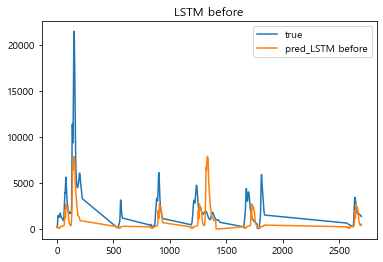

In [41]:
valid_predict[['true', f'pred_{model_name}']].plot()
plt.title(f"{model_name}")
plt.show()

## 5. DNN + t-1
 - DNN 모델 사용
 - t-1 데이터 사용

In [42]:
model_name = "DNN before"

In [43]:
scaler = RobustScaler()
scaler.fit(X_train)

X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

y_train_tensors = torch.Tensor(y_train.values).to(device)
y_valid_tensors = torch.Tensor(y_valid.values).to(device)

print(f"train data shape : {X_train_tensors.shape} valid data shape : {X_valid_tensors.shape}")
print(f"train label shape : {y_train_tensors.shape} valid label shape : {y_valid_tensors.shape}")

train data shape : torch.Size([1929, 42]) valid data shape : torch.Size([962, 42])
train label shape : torch.Size([1929]) valid label shape : torch.Size([962])


In [44]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [45]:
num_epochs = 10000
learning_rate = 0.01

input_size = X_train_tensors.shape[1]
hidden_layer = (1,1)
batch_norm = 1
drop_out = 1
drop_prob = 0.5

dnn = DNN(input_size, hidden_layer, batch_norm, drop_out, drop_prob).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(dnn.parameters(), lr=learning_rate)  # adam optimizer

In [46]:
best_loss = 1E+10
best_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = dnn(X_train_tensors)
    loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        dnn.eval()
        outputs_valid = dnn(X_valid_tensors)
        loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
        dnn.train()
        
    if loss_valid < best_loss:
        best_loss = loss_valid
        best_epoch = epoch
        best_model = copy.deepcopy(dnn)
    
    if (epoch+1) % (num_epochs//10) == 0:
        print("Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))

Epoch: 1000, Train Loss: 356460.22 Best Epoch: 947 Best Valid Loss: 470249.78
Epoch: 2000, Train Loss: 301134.88 Best Epoch: 947 Best Valid Loss: 470249.78
Epoch: 3000, Train Loss: 347202.88 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 4000, Train Loss: 282784.91 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 5000, Train Loss: 322947.31 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 6000, Train Loss: 273508.44 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 7000, Train Loss: 275023.34 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 8000, Train Loss: 274668.62 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 9000, Train Loss: 328783.03 Best Epoch: 2007 Best Valid Loss: 466846.53
Epoch: 10000, Train Loss: 252267.64 Best Epoch: 2007 Best Valid Loss: 466846.53


In [47]:
with torch.no_grad():
    best_model.eval()
    pred_valid = best_model(X_valid_tensors).view(-1).detach().cpu().numpy()

valid_predict[f'pred_{model_name}'] = pred_valid
valid_predict[f'error_{model_name}'] = abs(valid_predict['true'] - valid_predict[f'pred_{model_name}'])
valid_predict[f'error_percent_{model_name}'] = valid_predict[f'error_{model_name}'] / valid_predict['true'] * 100

In [48]:
mse = mean_squared_error(y_valid, pred_valid)

print(f"Mean Squared Error : {mse:.2f}")

mse_df.loc[model_name, 'MSE'] = mse
mse_df

Mean Squared Error : 466846.55


,MSE
Basic Model,2167162.55
XGB before,1929805.61
LSTM,8000352.21
LSTM before,6699314.20
DNN before,466846.55


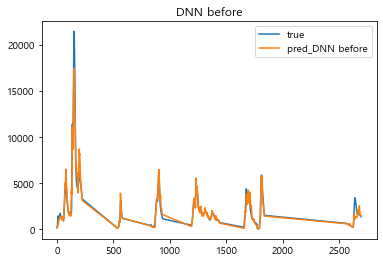

In [49]:
valid_predict[['true', f'pred_{model_name}']].plot()
plt.title(f"{model_name}")
plt.show()

## 6. DNN + t-1 + Robust 스케일러 사용
 - DNN 모델 사용
 - t-1 데이터 사용
 - Robust scaler 사용

In [50]:
model_name = "DNN before Robust"

In [51]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

y_train_tensors = torch.Tensor(y_train.values).to(device)
y_valid_tensors = torch.Tensor(y_valid.values).to(device)

print(f"train data shape : {X_train_tensors.shape} valid data shape : {X_valid_tensors.shape}")
print(f"train label shape : {y_train_tensors.shape} valid label shape : {y_valid_tensors.shape}")

train data shape : torch.Size([1929, 42]) valid data shape : torch.Size([962, 42])
train label shape : torch.Size([1929]) valid label shape : torch.Size([962])


In [52]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [53]:
num_epochs = 10000
learning_rate = 0.01

input_size = X_train_tensors.shape[1]
hidden_layer = (1,1)
batch_norm = 1
drop_out = 1
drop_prob = 0.5

dnn = DNN(input_size, hidden_layer, batch_norm, drop_out, drop_prob).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(dnn.parameters(), lr=learning_rate)  # adam optimizer

In [54]:
best_loss = 1E+10
best_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = dnn(X_train_tensors)
    loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        dnn.eval()
        outputs_valid = dnn(X_valid_tensors)
        loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
        dnn.train()
        
    if loss_valid < best_loss:
        best_loss = loss_valid
        best_epoch = epoch
        best_model = copy.deepcopy(dnn)
    
    if (epoch+1) % (num_epochs//10) == 0:
        print("Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))

Epoch: 1000, Train Loss: 297492.38 Best Epoch: 727 Best Valid Loss: 466217.56
Epoch: 2000, Train Loss: 305192.59 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 3000, Train Loss: 303867.28 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 4000, Train Loss: 297025.47 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 5000, Train Loss: 333658.69 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 6000, Train Loss: 286542.53 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 7000, Train Loss: 297180.62 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 8000, Train Loss: 278177.09 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 9000, Train Loss: 283968.56 Best Epoch: 1177 Best Valid Loss: 436115.16
Epoch: 10000, Train Loss: 313550.84 Best Epoch: 1177 Best Valid Loss: 436115.16


In [55]:
with torch.no_grad():
    best_model.eval()
    pred_valid = best_model(X_valid_tensors).view(-1).detach().cpu().numpy()

valid_predict[f'pred_{model_name}'] = pred_valid
valid_predict[f'error_{model_name}'] = abs(valid_predict['true'] - valid_predict[f'pred_{model_name}'])
valid_predict[f'error_percent_{model_name}'] = valid_predict[f'error_{model_name}'] / valid_predict['true'] * 100

In [56]:
mse = mean_squared_error(y_valid, pred_valid)

print(f"Mean Squared Error : {mse:.2f}")

mse_df.loc[model_name, 'MSE'] = mse
mse_df

Mean Squared Error : 436115.16


,MSE
Basic Model,2167162.55
XGB before,1929805.61
LSTM,8000352.21
LSTM before,6699314.20
DNN before,466846.55
DNN before Robust,436115.16


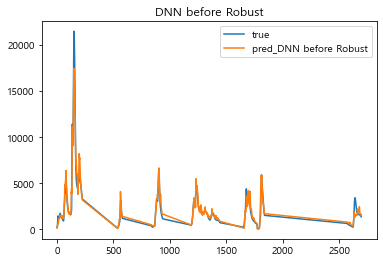

In [57]:
valid_predict[['true', f'pred_{model_name}']].plot()
plt.title(f"{model_name}")
plt.show()